# Linear Algebra with Transformers: Eigenvalue Problem


In this notebook we explore ideas from François Charton's paper  
[**"Linear Algebra with Transformers"**](https://arxiv.org/abs/2112.01898).

We focus on **how transformer can be applied to a nontrivial linear algebra task**: computing eigenvalues of symmetric matrices.

---

### What we will cover
1. **Motivation from the paper** – why linear algebra can be reframed as a sequence-to-sequence learning problem.  
2. **The eigenvalue task** – input: symmetric matrix; output: sorted eigenvalues.  
3. **Encoding and data generation** – how to represent matrices and eigenvalues as tokens for training.  
4. **Small-scale experiment** – training a toy Transformer model on generated data.  
5. **Evaluation and results** – comparing predicted vs. true eigenvalues, and discussing limitations.  
6. **Insights and wrap-up** – how this connects back to the broader claims of the paper.


## Can a **language model** learn **linear algebra**?  
Surprisingly, yes! 🤯

In 2021, François Charton asked exactly this question in the paper  
[**Linear Algebra with Transformers**](https://arxiv.org/abs/2112.01898).  

Instead of teaching a model to translate English to French,  
he trained it to **“translate” a matrix into its eigenvalues, determinant, or inverse**.  
The result: Transformers — designed for words — turned out to be powerful tools for **mathematics**.  

---

❓ **Guiding question for you:**  
If you were handed a random symmetric $3 \times 3$ matrix,  
how would *you* try to guess its eigenvalues?

In [ ]:
from abc import ABC, abstractmethod
import numpy as np
import matplotlib.pyplot as plt

import math
import itertools
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
np.random.seed(42)

## The Eigenvalue Challenge

Before we bring in Transformers, let’s set up the mathematical puzzle.  

A **symmetric matrix** is a square matrix equal to its transpose:
$$
A = A^\top
$$

Symmetric matrices are nice because:
* Their eigenvalues are always **real numbers**.  
* Their eigenvectors form an **orthogonal basis**.  


Here’s a random $3 \times 3$ symmetric matrix:  

👉 **Your challenge:** Can you guess its eigenvalues just by looking at it?  
(It’s not easy by hand — that’s the point!)

In [ ]:
# Generate a random symmetric 3x3 matrix
M = np.random.randint(-5, 6, size=(3, 3))
M = (M + M.T) // 2  # symmetrize

# Compute eigenvalues
eigvals, eigvecs = np.linalg.eigh(M)

print("Here is your matrix:")
print(M)

# Add slider/input for students to guess eigenvalues
import ipywidgets as widgets
from IPython.display import display

guesses = [widgets.FloatText(description=f"λ{i+1}", value=0.0) for i in range(3)]
button = widgets.Button(description="Check my guess")

out = widgets.Output()

def check_eigenvals(b):
    with out:
        out.clear_output()
        print("Your guesses:", [g.value for g in guesses])
        print("Actual eigenvalues:", np.round(eigvals, 2))

display(*guesses, button, out)
button.on_click(check_eigenvals)

---

### Reflection on the guessing game 🧩
Trying to guess eigenvalues directly from a random symmetric matrix is **hard**.  
Even for small $3 \times 3$ cases, the exact numbers depend on solving a cubic equation.  

But here’s the key insight:
- We can sometimes **estimate the magnitudes** of eigenvalues by looking at the size of the entries.  
- We can also often guess the **signs** (positive vs. negative) by the overall “balance” of the matrix.  
- What is almost impossible without calculation is to get the **precise values**.  

This illustrates why the problem is interesting:  
Eigenvalues are not “obvious” from raw numbers — they require nontrivial computation.  
And yet, Charton’s paper suggests that a Transformer model can *learn* this translation task!

## Why Transformers?

So… what do Transformers have to do with eigenvalues? 🤔  

Remember: Transformers are really good at **sequence-to-sequence translation**.  
And a matrix can be thought of as just that — a sequence of numbers.

- A **matrix** is a grid of entries.  
- If we **flatten** it row by row, we get a sequence:  
  $$
  [a_{11}, a_{12}, a_{13}, a_{21}, a_{22}, \dots, a_{33}]
  $$
- That sequence can be treated like a **sentence**.  

Now, suppose we invent a new translation problem:  
- **Input “sentence”** = the entries of a symmetric matrix.  
- **Output “sentence”** = its eigenvalues.  

---

### Analogy to natural language
- In NLP: *“Bonjour, je m’appelle Alice”* → *“Hello, my name is Alice”*.  
- In our setup: *“[2, 1, 1, 2, 1, 3, 1, 3, 4]”* → *“[0.2, 2.5, 5.3]”*.  

---

### The key idea  
We don’t hard-code the rules of linear algebra.  
Instead, we **train the Transformer** with many input–output pairs  
and let it discover the hidden structure by itself.  

This reframing is what makes the experiment exciting:  
**a language model can learn to “speak” linear algebra** ✨

## Data as Sequences

To train a Transformer, we need to phrase everything as **sequences**.

- **Input sequence:** the entries of a symmetric matrix, flattened row by row.  
- **Output sequence:** its eigenvalues, sorted for consistency.  

This way, the problem looks like machine translation:  
$$
\text{[matrix entries]} \;\;\;\longrightarrow\;\;\; \text{[eigenvalues]}
$$

---

### Example

Matrix:
$$
\begin{bmatrix}
2 & 1 & 1 \\
1 & 2 & 1 \\
1 & 1 & 3
\end{bmatrix}
$$

Input sequence: `[2, 1, 1, 1, 2, 1, 1, 1, 3]`  
Output sequence: `[1.0, 2.0, 4.0]`  

---

## Designing the Sequences

When framing linear algebra as a sequence-to-sequence task, we need to decide:  
**What exactly goes into the input and output sequences?**

Here are some important design choices:

1. **Matrix dimensions**
   - Should the input include the matrix size ($n$)?  
   - For fixed size (say $3 \times 3$), it’s unnecessary.  
   - But for variable sizes, including $n$ helps the model know *how long* the output sequence should be.  

2. **Precision of numbers**
   - Real eigenvalues can have many decimal places.  
   - We could:
     - Use **high precision** (e.g. 4–5 decimals) → better accuracy, but many more tokens.  
     - Use **rounded values** (e.g. 1 decimal place) → fewer tokens, easier training, but less precise results.  
   - There is a **tradeoff between token budget and accuracy**.  

3. **Tokenization strategy**
   - Treat each **entry as a single token** (e.g. “-3”, “4”).  
     - ✅ Keeps sequences shorter.  
     - ❌ Requires a large vocabulary (all possible integers/floats we might see).  
   - Treat each **digit as a token** (e.g. “-”, “3”, “.”, “4”).  
     - ✅ Small vocabulary (digits + symbols).  
     - ❌ Sequences get much longer, making training harder.  

4. **Ordering of entries**
   - Default: row by row (like reading a sentence).  
   - Alternatives: column by column, or even “upper triangle only” for symmetric matrices.  
   - Each choice may affect how easily the model learns patterns.  

---

### Takeaway
There is no single “best” encoding.  
- **Compact representations** (entry = token) help training speed.  
- **Fine-grained representations** (digit = token) increase flexibility but demand more data.  
- Including **dimensions** and controlling **precision** are crucial for consistency.  

This mirrors real NLP problems:  
How you tokenize and structure the data strongly influences what the Transformer can learn.

In [ ]:
def make_symmetric_matrix(n: int, low: int = -5, high: int = 5):
    """Generate a random symmetric n×n matrix with integer entries."""
    A = np.random.randint(low, high+1, size=(n, n))
    return (A + A.T) // 2  # force symmetry

def matrix_to_sequence(M: np.ndarray):
    """Flatten matrix row by row into a sequence of ints."""
    return M.flatten().tolist()

def eigen_to_sequence(M: np.ndarray):
    """Compute sorted eigenvalues as output sequence."""
    vals = np.linalg.eigvalsh(M)  # fast for symmetric matrices
    return np.round(np.sort(vals), 3).tolist()

# Example: make dataset of small symmetric matrices
def generate_dataset(num_samples=5, n=3):
    data = []
    for _ in range(num_samples):
        M = make_symmetric_matrix(n)
        x_seq = matrix_to_sequence(M)
        y_seq = eigen_to_sequence(M)
        data.append((x_seq, y_seq))
    return data

# Try it out
dataset = generate_dataset(num_samples=3, n=3)
for i, (x, y) in enumerate(dataset):
    print(f"Sample {i+1}")
    print("Input sequence (matrix):", x)
    print("Output sequence (eigenvalues):", y)
    print("---")

In [ ]:
!git clone https://github.com/facebookresearch/lawt.git
%cd lawt

In the paper https://arxiv.org/pdf/2112.01898) the following problems were considered:

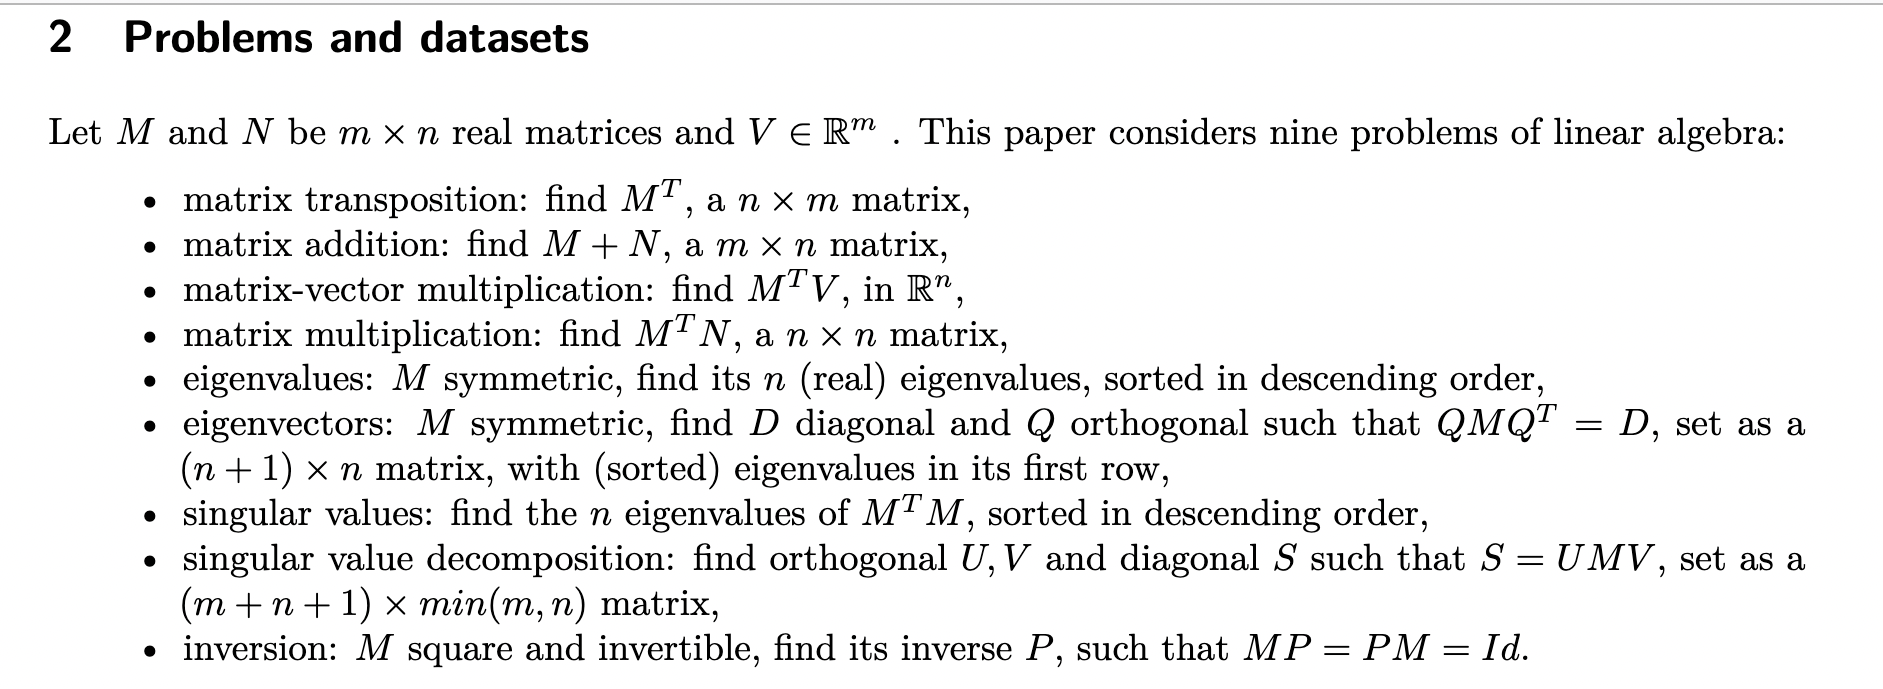

We will apply the Transformer model to the <font color='red'>**eigenvalue problem**</font>. First, let us load model parameters from https://github.com/facebookresearch/LAWT

In [ ]:
import torch
!curl -O https://dl.fbaipublicfiles.com/LAWT/eigenvalue_semicircle.tar.gz
!tar -xzvf eigenvalue_semicircle.tar.gz

## Encoding

We need to **encode** our matrices. Four encoding types are used in https://arxiv.org/pdf/2112.01898

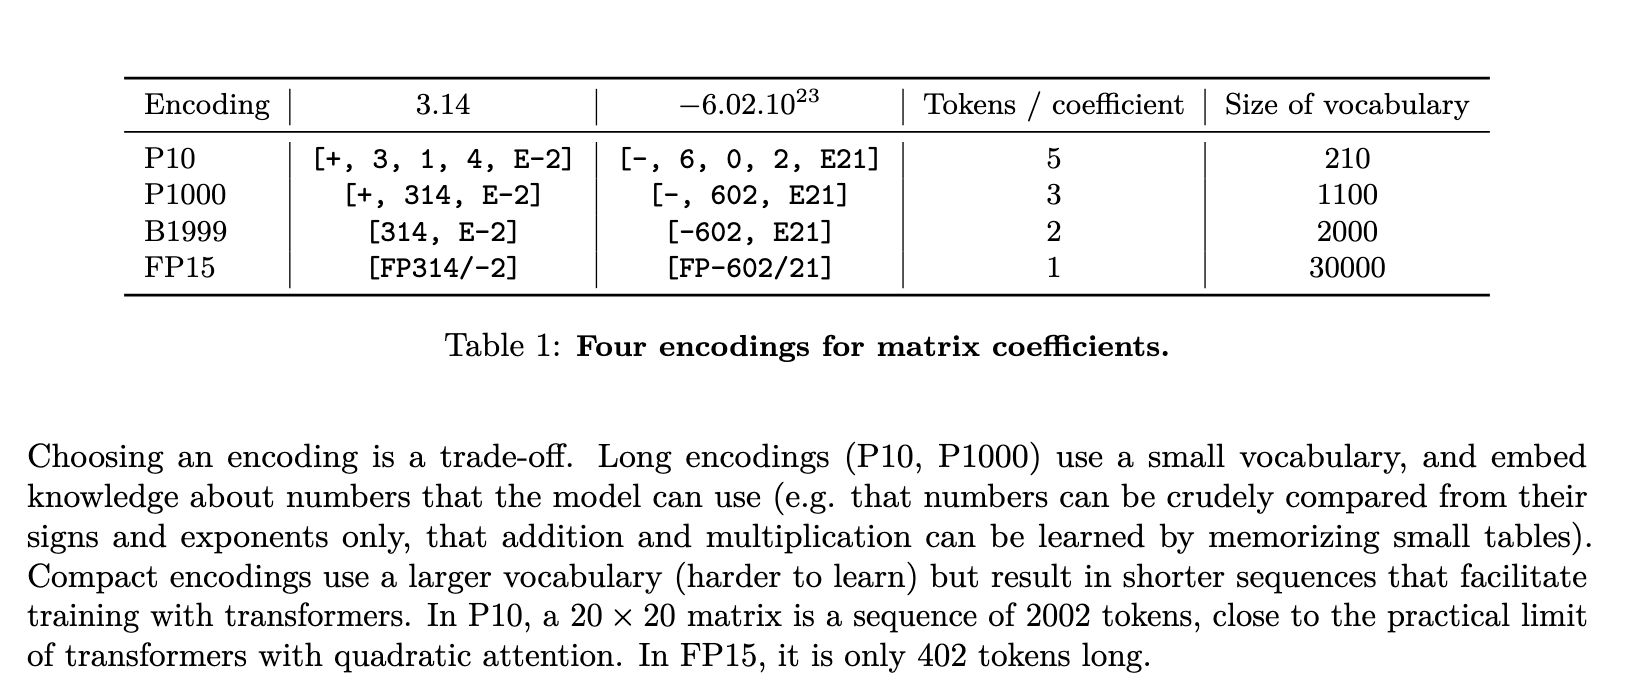

The loaded parameters specify the encodings used:

*   FP15 for input,
*   P1000 for output.




In [ ]:
# Load the model parameters and map to the CPU
state_dict = torch.load('best-valid_numeric_beam_acc.pth', map_location=torch.device('cpu'))
print(state_dict.keys())
print()

loaded_params = state_dict['params']
loaded_params["input_encoding"], loaded_params["output_encoding"]

The following function is needed for embedding the encodings.

In [ ]:
def Embedding(num_embeddings, embedding_dim, padding_idx=None):
    m = nn.Embedding(num_embeddings, embedding_dim, padding_idx=padding_idx)
    nn.init.normal_(m.weight, mean=0, std=embedding_dim ** -0.5)
    if padding_idx is not None:
        nn.init.constant_(m.weight[padding_idx], 0)
    return m

### Encoder

The encoder is implemented as an abstract class. Abstract functions allow for derived class definitions, enabling the creation of various encoder implementations. The matrix encoding process is demonstrated in the example below.

We use the code from https://github.com/facebookresearch/LAWT/blob/main/src/envs/encoders.py


In [ ]:
from abc import ABC, abstractmethod
import numpy as np
import math

class Encoder(ABC):
    """
    Base class for encoders, encodes and decodes matrices
    abstract methods for encoding/decoding numbers
    """
    def __init__(self, max_dimension, precision):
        self.max_encoder_dimension = max_dimension
        self.float_precision = precision
        self.symbols = ["V" + str(i) for i in range(1, self.max_encoder_dimension + 1)]
        self.limit = -1

    @abstractmethod
    def write_float(self, val):
        pass

    @abstractmethod
    def parse_float(self, lst):
        pass

    def encode(self, matrix):
        lst = []
        l, c = np.shape(matrix)
        lst.append("V" + str(l))
        lst.append("V" + str(c))
        for line in matrix:
            for val in line:
                lst.extend(self.write_float(val))
        return lst

    def decode(self, lst):
        if len(lst) < 2 or lst[0][0] != "V" or lst[1][0] != "V":
            return None
        nr_lines = int(lst[0][1:])
        nr_cols = int(lst[1][1:])
        h = lst[2:]
        m = np.zeros((nr_lines, nr_cols), dtype=float)
        for i in range(nr_lines):
            for j in range(nr_cols):
                val, pos = self.parse_float(h)
                if np.isnan(val):
                    return None
                h = h[pos:]
                m[i, j] = val
        return m

### 1.1.2 FP15 encoder

In [ ]:
class FPSymbol(Encoder):
    def __init__(self, params, precision, max_exponent):
        super().__init__(params["max_encoder_dimension"], precision)
        self.max_exponent = max_exponent
        assert (self.float_precision + self.max_exponent) % 2 == 0
        self.symbols.extend(["NaN", "-NaN"])
        dig = 10 ** self.float_precision
        self.logrange = (self.float_precision + self.max_exponent) // 2
        self.base = 10 ** (self.logrange - self.float_precision)
        self.limit = 10 ** self.logrange
        self.output_length = 1
        # less than 1
        self.symbols.extend(["N" + str(i) + "e0" for i in range(-dig + 1, dig)])
        for i in range(self.max_exponent):
            for j in range(1, 10):
                for k in range(dig):
                    self.symbols.append("N" + str(j * dig + k) + "e" + str(i))
                    self.symbols.append("N-" + str(j * dig + k) + "e" + str(i))

    def write_float(self, value):
        if abs(value) > self.limit:
            return ["NaN"] if value > 0 else ["-NaN"]
        sign = -1 if value < 0 else 1
        v = abs(value) * self.base
        if v == 0:
            return ["N0e0"]
        e = int(math.log10(v))
        if e < 0:
            e = 0
        m = int(v * (10 ** (self.float_precision - e)) + 0.5)
        if m == 0:
            sign = 1
        if m == 1000:
            m = 100
            e += 1
        if e >= self.max_exponent:
            return ["NaN"] if value > 0 else ["-NaN"]
        pref = "N" if sign == 1 else "N-"
        return [pref + str(m) + "e" + str(e)]

    def parse_float(self, lst):
        if len(lst) == 0:
            return np.nan, 0
        if lst[0] == "NaN":
            return self.limit, 1
        if lst[0] == "-NaN":
            return -self.limit, 1
        if lst[0][0] != "N":
            return np.nan, 1
        m, e = lst[0][1:].split("e")
        v = (int(m) * (10 ** int(e))) / self.limit
        return v, 1

### 1.1.3 P1000 encoder

In [ ]:
class Positional(Encoder):
    def __init__(self, params, prec, base_int):
        super().__init__(params["max_encoder_dimension"], prec)
        self.base = base_int

        self.symbols.extend([str(i) for i in range(self.base)])
        self.symbols.extend(['E' + str(i) for i in range(-100, 101)])
        self.limit = 10.0 ** 101
        # WARNING adjust this at some point
        self.output_length = 5 if base_int == 10 else 3

    def gobble_int(self, lst):
        res = 0
        i = 0
        for x in lst:
            if not (x.isdigit()):
                break
            res = res * self.base + int(x)
            i += 1
        return res, i

    def write_posint(self, value):
        if value == 0:
            return ["0"]
        seq = []
        v = value
        while v > 0:
            seq.append(str(v % self.base))
            v = v // self.base
        return seq[::-1]

    def write_float(self, value):
        """
        Write a float number
        """
        precision = self.float_precision
        assert value not in [-np.inf, np.inf]
        m, e = (f"%.{precision}e" % abs(value)).split("e")
        i, f = m.split(".")
        i = i + f
        ipart = int(i)
        fpart = 0
        expon = int(e) - precision
        if expon < -100:
            ipart = 0
            fpart = 0
        if ipart == 0 and fpart == 0:
            value = 0.0
            expon = 0
        res = ["+"] if value >= 0.0 else ["-"]
        res = res + self.write_posint(ipart)
        if fpart != 0:
            res.append('.')
            res = res + self.write_posint(fpart)
        return res + ["E" + str(expon)]

    def parse_float(self, lst):
        """
        Parse a list that starts with a float.
        Return the float value, and the position it ends in the list.
        """
        if len(lst) < 2 or lst[0] not in ["+", "-"]:
            return np.nan, 0
        sign = -1 if lst[0] == "-" else 1
        pos = 1
        mant, i = self.gobble_int(lst[pos:])
        if i == 0:
            return np.nan, pos
        pos += i
        if len(lst) > pos and lst[pos] == ".":
            pos += 1
            base_mul = 1.0
            mul, i = self.gobble_int(lst[pos:])
            mul *= base_mul
            mul /= 10 ** self.float_precision
            pos += i
            mant += mul
        mant *= sign
        if len(lst) > pos and lst[pos] == "10^":
            pos += 1
            if lst[pos] not in ["+", "-"]:
                return np.nan, pos
            signexp = -1 if lst[pos] == "-" else 1
            pos += 1
            exp, i = self.gobble_int(lst[pos:])
            exp *= signexp
            if i == 0:
                return np.nan, pos
            pos += i
        elif len(lst) > pos and lst[pos][0] == "E":
            exp = int(lst[pos][1:])
            pos += 1
        else:
            exp = 0
        try:
            value = mant * (10 ** exp)
        except Exception:
            return np.nan, pos
        return value, pos

### 1.1.4 Examples of encodings

The next example demonstrates the encoding.

In [ ]:
def encode_decode_matrix(encoder):
  # Create a 2x2 matrix
  a, b = 5, 5
  matrix = 20 * np.random.rand(a, b) - 10  # Example matrix with random values in [-10,10]
  print("Original Matrix:")
  print(matrix)

  # Encode the matrix
  encoded_matrix = encoder.encode(matrix)
  print("\nEncoded Matrix:")
  print(encoded_matrix)

  # Decode the matrix
  decoded_matrix = encoder.decode(encoded_matrix)
  print("\nDecoded Matrix:")
  print(decoded_matrix)

Encoder:

In [ ]:
# Initialize the encoder
encoder_params = {
    "max_encoder_dimension": 100
}

encoder_prec = 2
encdoder_max_exponent = 16
input_encoder = FPSymbol(params=encoder_params, precision=encoder_prec, max_exponent=encdoder_max_exponent)

encode_decode_matrix(input_encoder)

Decoder:

In [ ]:
decoder_params = {
    "max_encoder_dimension": 100
}
decoder_prec =  2
decoder_base_int = 1000
output_encoder = Positional(params=decoder_params, prec=decoder_prec, base_int=decoder_base_int)

encode_decode_matrix(output_encoder)

In [ ]:
class TransformerFFN(nn.Module):
    def __init__(self, in_dim, dim_hidden, out_dim, dropout):
        super().__init__()
        self.dropout = dropout
        self.act = F.relu
        self.lin1 = nn.Linear(in_dim, dim_hidden)
        self.lin2 = nn.Linear(dim_hidden, out_dim)

    def forward(self, input):
        x = self.lin1(input)
        x = self.act(x)
        x = self.lin2(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x

Due to its length, we omit the Transformer model code. Instead, we download the code directly from

https://raw.githubusercontent.com/facebookresearch/LAWT/main/src/model/transformer.py.



In [ ]:
!curl -O https://raw.githubusercontent.com/facebookresearch/LAWT/main/src/model/transformer.py
from transformer import TransformerModel

## Load Models

### Dictionary and Embeddings

We begin by initializing the encoders and embedding dictionaries.

In [ ]:
# Initialize the encoder
encoder_params = {
    "max_encoder_dimension": 100
}

encoder_prec = 2
encdoder_max_exponent = 16

input_encoder = FPSymbol(params=encoder_params, precision=encoder_prec, max_exponent=encdoder_max_exponent)

decoder_params = {
    "max_encoder_dimension": 100
}
decoder_prec =  2
decoder_base_int = 1000
output_encoder = Positional(params=decoder_params, prec=decoder_prec, base_int=decoder_base_int)

Embedding Dictionaries:

In [ ]:
SPECIAL_WORDS = ["<s>", "</s>", "<pad>", "(", ")"] + [
    f"<SPECIAL_{i}>" for i in range(10)
] + ['T', 'A', 'D', 'M', 'E', 'F', 'I']

common_symbols = ['+', '-', '10^', '.', '|']
words = SPECIAL_WORDS + common_symbols + sorted(list(
            set(output_encoder.symbols + input_encoder.symbols)
        ))
id2word = {i: s for i, s in enumerate(words)}
word2id = {s: i for i, s in id2word.items()}
print(len(id2word))

### Transformer's Encoder

The parameters are taken from https://github.com/facebookresearch/LAWT/blob/main/sweeps/eigenvalues.json

In [ ]:
from collections import namedtuple

N_MAX_POSITIONS = 4096  # maximum input sequence length

# Define a Parameters namedtuple for the model configuration
Params = namedtuple('Params', [
    'n_words', 'eos_index', 'pad_index', 'enc_emb_dim', 'dec_emb_dim',
    'n_enc_heads', 'n_dec_heads', 'n_enc_layers', 'n_dec_layers',
    'dropout', 'attention_dropout', 'sinusoidal_embeddings',
    'share_inout_emb', 'fp16', 'batch_size'
])

# Set up the transformer parameters
params = Params(
    n_words = len(id2word),
    eos_index = 0,
    pad_index = 1, 

    fp16 = True,

    # Encoder parameters
    enc_emb_dim = 512,
    n_enc_layers = 6,
    n_enc_heads = 8,

    # Decoder parameters
    dec_emb_dim = 512,
    n_dec_layers = 1,
    n_dec_heads = 8,
    dropout = 0,
    attention_dropout = 0,

    batch_size = 64,

    sinusoidal_embeddings = False,
    share_inout_emb = True,
)

We will now observe the Encoder architecture.






In [ ]:
encoder = TransformerModel(params=params, id2word=id2word, is_encoder =True, with_output=False)
encoder.eval()

### Transformer's Decoder

The Decoder structure:

In [ ]:
decoder = TransformerModel(params=params, id2word=id2word, is_encoder =False, with_output=True)
decoder.eval()

### Load weights

In [ ]:
# Load the state dictionary from the checkpoint file
checkpoint = torch.load("best-valid_numeric_beam_acc.pth", map_location=torch.device('cpu'))

# Print the available keys in the checkpoint file
print(checkpoint.keys())

encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])
print("Parameters loaded successfully.")


### Experiment

We begin by generating a $5\times 5$ matrix with random values between $-10$ and $10$.

In [ ]:
# Create a 5x5 matrix
a, b = 5, 5
np.random.seed(42)  # Set the random seed for reproducibility
matrix = 20 * np.random.rand(a, b) - 10  # Example matrix with random values in [-10,10]
matrix = (matrix + matrix.T) / 2
print("Original Matrix:")
print(matrix)

# Encode the matrix
encoded_matrix = input_encoder.encode(matrix)
print("\nEncoded Matrix:")
print(encoded_matrix)

We transform Encoded Matrix into a LongTensor.

In [ ]:
# Replace matrix values with numerical IDs using word2id
numerical_matrix = []
for value in encoded_matrix:
    numerical_matrix.append(word2id[str(value)])

# Convert the numerical matrix to a PyTorch LongTensor
long_tensor = torch.tensor(numerical_matrix, dtype=torch.long).unsqueeze(1)

print("Original Encoded Matrix:\n", encoded_matrix)
print("\nNumerical Matrix:\n", numerical_matrix)
# print("\nLongTensor:\n", long_tensor)
print(long_tensor.shape)


We apply the Encoder.

In [ ]:
"""
Inputs (of the Encoder):
    `x` LongTensor(slen, bs), containing word indices
    `lengths` LongTensor(bs), containing the length of each sentence
    `causal` Boolean, if True, the attention is only done over previous hidden states
    `positions` LongTensor(slen, bs), containing word positions
"""
lengths_tensor = torch.tensor([long_tensor.shape[0]], dtype=torch.long)
print(lengths_tensor)

encoded = encoder("fwd", x=long_tensor, lengths=lengths_tensor, causal=False)
print(encoded.shape)
print(encoded)

We generate an answer using the Decoder.

We convert the generated LongTensor to P1000 encoding.

In [ ]:
dec_length = torch.tensor([encoded.shape[0]], dtype=torch.long)

generated, gen_len = decoder.generate(
    src_enc=encoded.transpose(0, 1),
    src_len=dec_length,
)

print(generated.reshape(-1,))

In [ ]:
generated_list = []
for i in range(generated.shape[0]):
  generated_list.append([id2word[idx.item()] for idx in generated[i]][0])
print(generated_list)

In [ ]:
# Decode the matrix
answer = output_encoder.decode(generated_list[1:])
print("\nDecoded Matrix:")
print(answer)

The eigenvalues of the original matrix:

In [ ]:
# Calculate eigenvalues
eigenvalues = np.linalg.eigvals(matrix)

print("Eigenvalues of the matrix:")
np.sort(eigenvalues)[::-1]